# Importing required packages
* tesnsorflow, numpy, pandas
* cv2 for drawing rectangle on images
* tdqm for showing progress bar
* shutil for copying images

In [107]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random

from tqdm.auto import tqdm
import shutil as sh
from PIL import Image

# Importing images for training our custom traning set
* **train_dir**: training images 
* **test_dir**: testing images
* **data**: value of boxes co-ordinates on images(xmin,ymin,xmax,ymax)

In [108]:
train_dir = "data/training_images/"
test_dir = "data/testing_images/"

print('Image(train): ', len(os.listdir(train_dir)))
print('Image(test): ', len(os.listdir(test_dir)))

Image(train):  1001
Image(test):  175


In [109]:
data = pd.read_csv("data/train_solution_bounding_boxes (1).csv")

In [110]:
data.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [111]:
print(data.shape)
data.nunique()

(559, 5)


image    355
xmin     440
ymin     149
xmax     438
ymax     184
dtype: int64

# Showing training Images with green boxes on car

(380, 676, 3)
Name,xmin,ymin,xmax,ymax: image    vid_4_21300.jpg
xmin          490.124457
ymin          181.655405
xmax          667.195369
ymax          241.809846
Name: 251, dtype: object
(380, 676, 3)
Name,xmin,ymin,xmax,ymax: image    vid_4_3220.jpg
xmin         444.144718
ymin         188.013192
xmax         557.626628
ymax         231.539575
Name: 397, dtype: object
(380, 676, 3)
Name,xmin,ymin,xmax,ymax: image    vid_4_16020.jpg
xmin          244.083936
ymin          193.392857
xmax          338.978292
ymax          237.897362
Name: 119, dtype: object
(380, 676, 3)
Name,xmin,ymin,xmax,ymax: image    vid_4_19880.jpg
xmin          434.361794
ymin          182.633526
xmax          558.115774
ymax          230.561454
Name: 212, dtype: object


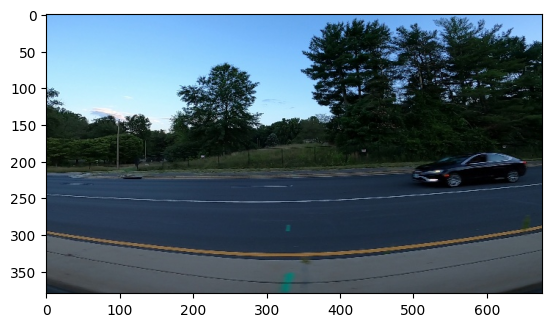

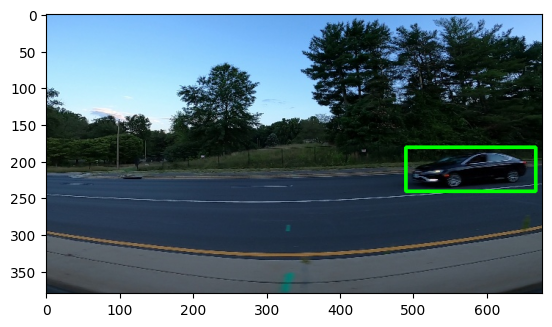

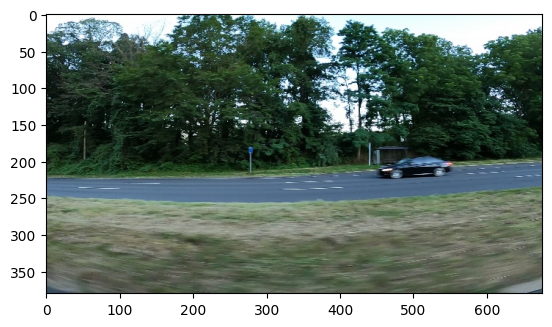

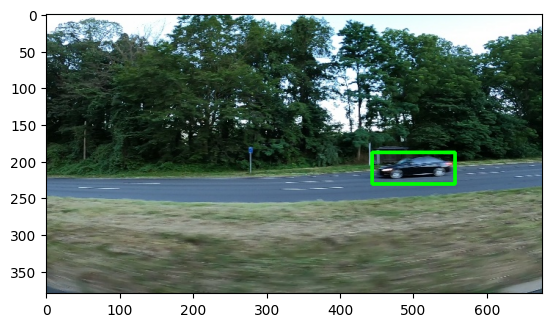

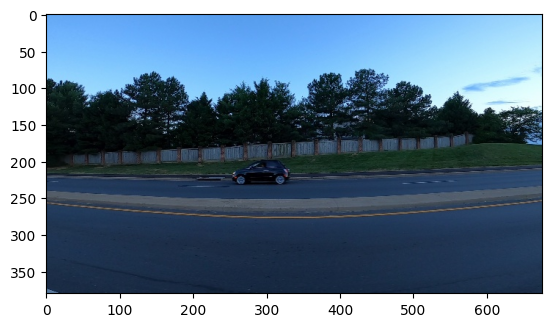

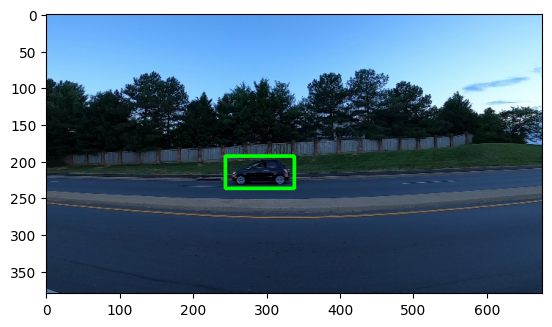

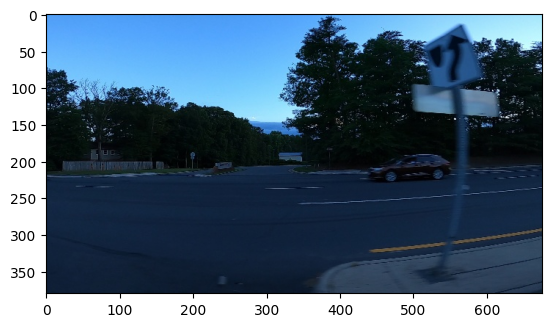

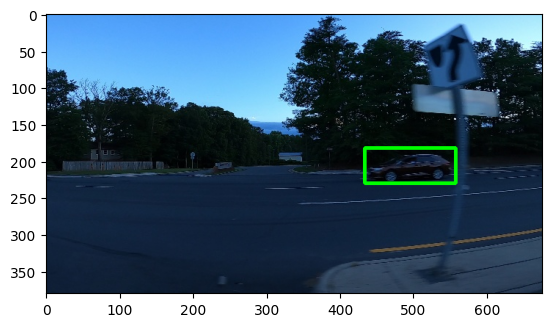

In [112]:
IMAGE_SHAPE = 0
for i in range(4):
    rand = np.random.randint(0, data.shape[0])
    random_row = data.iloc[rand]
    image = plt.imread(train_dir + random_row[0])
    plt.figure()
    plt.imshow(image)
    IMAGE_SHAPE = image.shape
    print(image.shape)
    print('Name,xmin,ymin,xmax,ymax:',random_row)
    point1 = (int(random_row[1]), int(random_row[2]))
    point2 = (int(random_row[3]), int(random_row[4]))
    cv2.rectangle(image, point1, point2, color=(0, 255, 0), thickness=3)
    plt.figure()
    plt.imshow(image)

# Cloning yolov5 from github

**Link:** https://github.com/ultralytics/yolov5 

In [113]:
!git clone https://github.com/ultralytics/yolov5
!cd yolov5
!pip install -r ./yolov5/requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


# Data processing

Converting (xmin,ymin,xmax,ymax) to (x_center,y_center, w, h) as yolo5 required that format.

In [114]:
im_h, im_w, num_chanels = IMAGE_SHAPE
data["x_center"] = (data["xmax"] + data["xmin"])/2
data["y_center"] = (data["ymax"] + data["ymin"])/2
data["w"] = data["xmax"] - data["xmin"]
data["h"] = data["ymax"] - data["ymin"]
data["classes"] = 0
#Normalizing the values with image height and width
data["x_center"] = data["x_center"]/im_w
data["w"] = data["w"]/im_w
data["y_center"] = data["y_center"]/im_h
data["h"] = data["h"]/im_h
data.head()

image        xmin        ymin        xmax        ymax  x_center  \
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547  0.450434   
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180  0.100217   
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180  0.444645   
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575  0.833213   
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422  0.110347   

   y_center         w         h  classes  
0  0.539817  0.068741  0.095238        0  
1  0.557191  0.155572  0.129987        0  
2  0.543678  0.181621  0.157014        0  
3  0.531451  0.197540  0.155727        0  
4  0.559122  0.171491  0.136422        0

In [115]:
index = list(data.image)
print(len(index))

559


# Training with yolov5 model

First we are going create a folder "data/fold0" and divide our training images into train and validation set. We are going to create a txt file for each images with box co-ordinates(x_center, y_center, w, h).

**STEP-1: Creating a txt file for each images inside labels folder**

validation set: "data/fold0/labels/val/"

training set: "data/fold0/labels/train/"

**STEP-2: Copying images from each Input to folder**

validation images: "data/fold0/images/val/"

training images: "data/fold0/images/train/"

**STEP-3: Creating dataset.yaml**

Creating a dataset.yaml file as required for custom training the yolov5 model,which contains path to training data and validation data.

**STEP-4: Training the model with custom data**

We are going to train the model with:

    - Batch size = 12
    - Epochs = 12
    - CONF_TRESHOLD = 0.6
    - IOU_THRESHOLD = 0.5
    - MODEL = 'yolov5x.pt' (large model for better output)

In [116]:
if not os.path.exists("data"):
    os.makedirs("data")
    os.makedirs("data/fold{}".format(0))

In [117]:
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(data.groupby('image')):
            if name in val_index:
                path2save = 'val/'
            else:
                path2save = 'train/'
            if not os.path.exists('data/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('data/fold{}/labels/'.format(fold)+path2save)
            with open('data/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('data/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('data/fold{}/images/{}'.format(fold,path2save))
            sh.copy("data/{}/{}".format(source,name),'data/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))
        print("Copy done")
        print('Image(train): ', len(os.listdir('data/fold0/images/train/')))
        print('Image(test): ', len(os.listdir('data/fold0/images/val/')))

100%|██████████| 355/355 [00:00<00:00, 1324.87it/s]

Copy done
Image(train):  281
Image(test):  74


In [125]:
%%writefile dataset.yaml
path: data/fold0
train: data/fold0/images/train
val: data/fold0/images/val
test:

names:
    0: car

Overwriting dataset.yaml


In [119]:
IMG_SIZE = IMAGE_SHAPE[1]
CONF_TRESHOLD = 0.6
IOU_THRESHOLD = 0.5
MODEL = 'yolov5x.pt'

In [120]:
import time

start = time.perf_counter()

!python yolov5/train.py --batch 3 --epochs 3 --data dataset.yaml --weights {MODEL} --name my_model_5x

end = time.perf_counter()

total_time = end - start

print(f'Training time for {MODEL} model is: {total_time:0.2f} seconds')

train: weights=yolov5x.pt, cfg=, data=dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=3, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=my_model_5x, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.9.13 torch-1.13.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0

In [ ]:
!ls yolov5/runs/train/my_model_5x18/

F1_curve.png
PR_curve.png
P_curve.png
R_curve.png
confusion_matrix.png
events.out.tfevents.1677926682.CRDL-LAP-0037.local.6237.0
hyp.yaml
labels.jpg
labels_correlogram.jpg
opt.yaml
results.csv
results.png
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
val_batch0_labels.jpg
val_batch0_pred.jpg
val_batch1_labels.jpg
val_batch1_pred.jpg
val_batch2_labels.jpg
val_batch2_pred.jpg
weights


# Detecting cars on test images

We are now going to use our custom trained model to detect cars on our testing images. The wieghts of our train model are inside "yolov5/runs/train/my_model_5x/weights/best.pt".

In [123]:
!python ./yolov5/detect.py --img {IMG_SIZE} --conf {CONF_TRESHOLD} --iou-thres {IOU_THRESHOLD} --source {test_dir} --weights yolov5/runs/train/my_model_5x18/weights/best.pt

detect: weights=['yolov5/runs/train/my_model_5x18/weights/best.pt'], source=data/testing_images/, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.6, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.9.13 torch-1.13.1 CPU

Fusing layers... 
Model summary: 322 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/175 /Users/vikassingh/demo/python/Real-Time-Object-Detection-With-OpenCV/data/testing_images/vid_5_25100.jpg: 416x704 (no detections), 399.1ms
image 2/175 /Users/vikassingh/demo/python/Real-Time-Object-Detection-With-OpenCV/data/testing_images/v

In [74]:
!ls yolov5/runs/detect/exp/

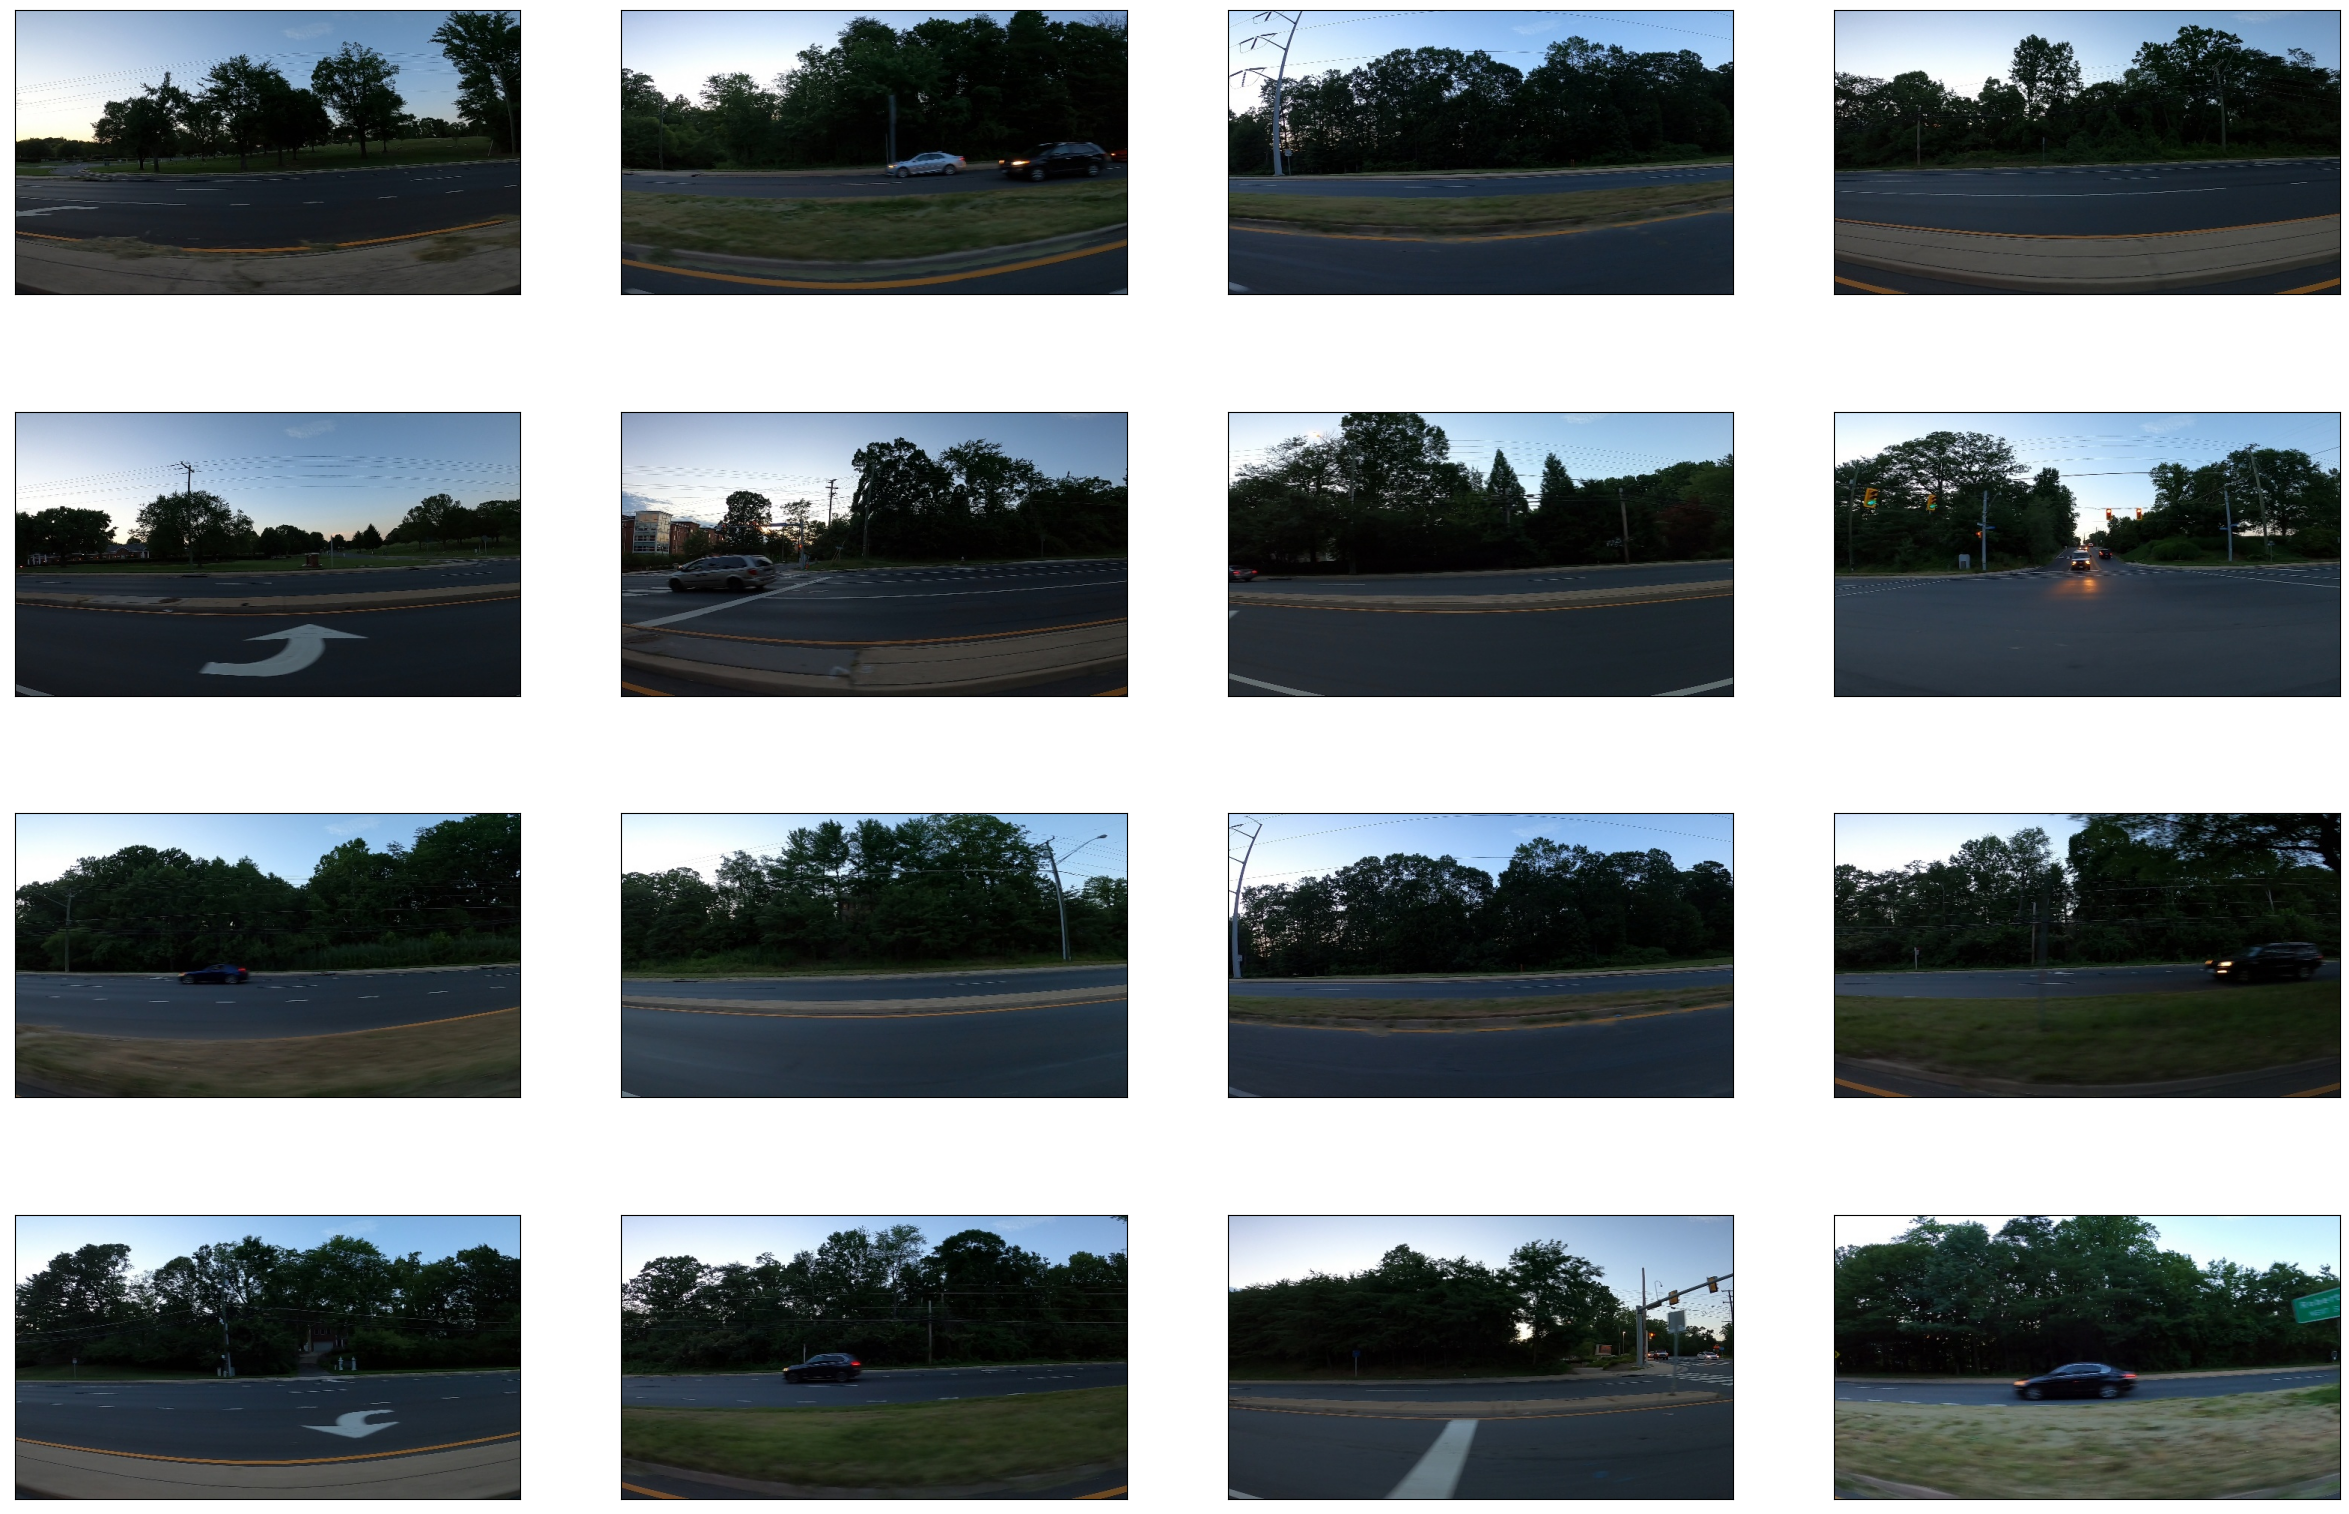

In [124]:
pred_dir = './yolov5/runs/detect/exp5'
file_paths = []
flist = os.listdir(pred_dir)
for file in flist:
    fpath = os.path.join(pred_dir, file)
    file_paths.append(fpath)

plt.figure(figsize=(30, 20))
for i in range(16):
    random = np.random.randint(0, len(file_paths) - 1)
    plt.subplot(4, 4, i + 1)
    img_path = file_paths[random]
    img = plt.imread(img_path)
    plt.imshow(img)
    #plt.title('Predictions', size=10, color="black") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()